In [1]:
import cv2

In [2]:
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import gzip,pickle,sys
import numpy as np
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
#from keras import backend as K
import PIL
import numpy as np
import random
import matplotlib.pyplot as plt
from random import randint
import os
import shutil
import pandas as pd
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4549169384385437080,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3048682292
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8385330481761353617
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [5]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
batch_size = 32
img_height = 50
img_width = 50
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']
data_dir = './dataset/'

In [7]:
#pip install split-folders

In [8]:
#splitting the dataset

#import splitfolders
#splitfolders.ratio(data_dir, output="Split Dataset", seed=1337, ratio=(.8, 0.15,0.05))


In [5]:
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                #img_arr = cv2.cvtColor(img_arr, cv2.COLOR_RGB2GRAY)
                resized_arr = cv2.resize(img_arr, (img_height, img_width)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [7]:
train = get_data('./Split Dataset/train')
val = get_data('./Split Dataset/val')
test = get_data('./Split Dataset/test')

<ipython-input-5-3d0cf0acaeac>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(data)


In [8]:
print(train.shape)
print(test.shape)
print(val.shape)

(7199, 2)
(466, 2)
(1343, 2)


Text(0.5, 1.0, '0')

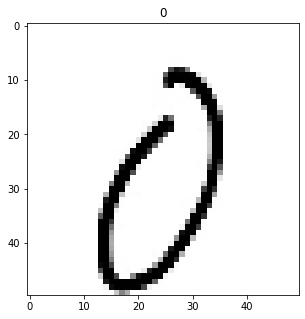

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(train[5][0])
plt.title(labels[train[5][1]])

Image label: 10


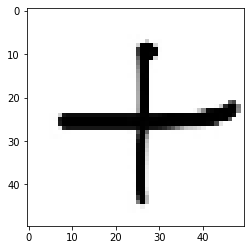

In [9]:
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test = []
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)


# Normalize the data
x_train = np.array(x_train)
x_val = np.array(x_val)
x_test = np.array(x_test)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

x_train.reshape(-1, img_height, img_width, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_height, img_width, 1)
y_val = np.array(y_val)

x_test.reshape(-1, img_height, img_width, 1)
y_test = np.array(y_test)

plt.imshow(x_val[820])
print("Image label: "+str(y_val[820]))

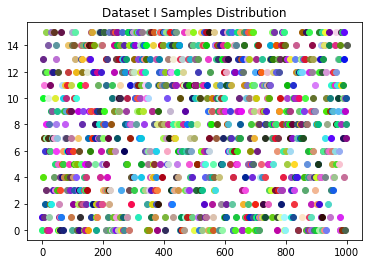

In [14]:
a = np.arange(0,1000,1)
#taking thousand random samples
b = np.random.choice(y_train, size=1000, replace=False)

#print(a, b)

for x, y in zip(a, b):
    rgb = np.random.rand(3,)
    plt.scatter(x, y, c=[rgb])
plt.title("Dataset I Samples Distribution")
plt.show()

In [13]:
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

x_train shape: (7199, 50, 50, 3)
x_val shape: (1343, 50, 50, 3)
x_test shape: (466, 50, 50, 3)
7199 train samples
1343 validation samples
466 test samples


In [14]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val = keras.utils.to_categorical(y_val, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

In [15]:
num_classes = 16
img_channels = 3

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', 
                 activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros',
                 input_shape=(img_height, img_width, img_channels)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same',  activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(Conv2D(256, (3, 3),padding='same',  activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 128)       0

In [17]:
#using Sparse Categorical Crossentropy
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
#using Categorical Crossentropy

#model.compile(loss=keras.losses.categorical_crossentropy ,
              #optimizer=keras.optimizers.Adadelta(),
              #metrics=['accuracy'])


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [20]:
earlystopper = EarlyStopping(patience=10, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [21]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [22]:
print(x_train.shape)
print(y_train.shape)

(7199, 50, 50, 3)
(7199,)


In [23]:
datagen = ImageDataGenerator(
        featurewise_center=True,  # set input mean to 0 over the dataset
        samplewise_center=True,  # set each sample mean to 0
        featurewise_std_normalization=True,  # divide inputs by std of the dataset
        samplewise_std_normalization=True,  # divide each input by its std
        zca_whitening=True,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images




C:\Users\rafir\anaconda3\envs\Rafi\lib\site-packages\keras_preprocessing\image\image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [24]:
datagen.fit(x_train)

In [25]:
#using augmentation

epochs = 100

history=model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val), callbacks = [MetricsCheckpoint('logs'), earlystopper,learning_rate_reduction])
print(history)
model.save_weights("modelWeight.h5")
print('Save model to disk')
score = model.evaluate(x_test, y_test, verbose=0)

print(' Training Complete ')
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

Epoch 1/100
225/225 [==============================] - 19s 51ms/step - loss: 2.5905 - accuracy: 0.1422 - val_loss: 1.1977 - val_accuracy: 0.6977
Epoch 2/100
225/225 [==============================] - 9s 38ms/step - loss: 1.2189 - accuracy: 0.6257 - val_loss: 0.3910 - val_accuracy: 0.8786
Epoch 3/100
225/225 [==============================] - 9s 38ms/step - loss: 0.6219 - accuracy: 0.8061 - val_loss: 0.2231 - val_accuracy: 0.9337
Epoch 4/100
225/225 [==============================] - 9s 38ms/step - loss: 0.4296 - accuracy: 0.8669 - val_loss: 0.2097 - val_accuracy: 0.9337
Epoch 5/100
225/225 [==============================] - 9s 38ms/step - loss: 0.3178 - accuracy: 0.9009 - val_loss: 0.1180 - val_accuracy: 0.9620
Epoch 6/100
225/225 [==============================] - 9s 38ms/step - loss: 0.2774 - accuracy: 0.9162 - val_loss: 0.0994 - val_accuracy: 0.9724
Epoch 7/100
225/225 [==============================] - 9s 38ms/step - loss: 0.2282 - accuracy: 0.9328 - val_loss: 0.1487 - val_accuracy

In [26]:
range(earlystopper.stopped_epoch)

range(0, 38)

In [27]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

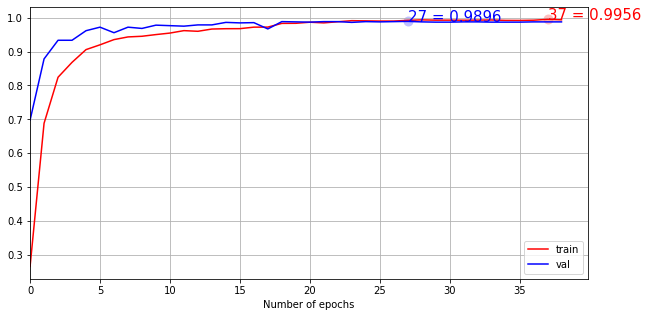

In [28]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis=1) 
y_true = np.argmax(y_test,axis=0)
plotKerasLearningCurve()
plt.show() 

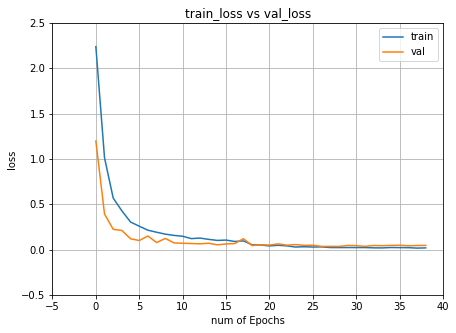

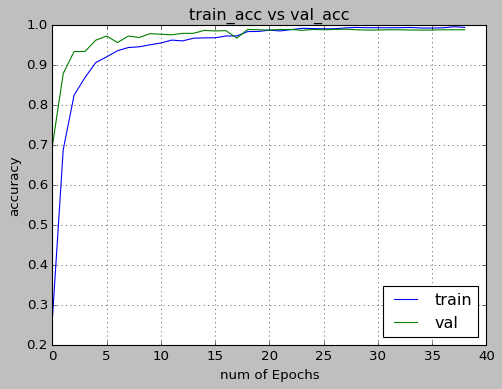

In [29]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

xc=range(earlystopper.stopped_epoch+1)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.show()

In [30]:
model_json=model.to_json()
with open ("model.json","w") as json_file:
    json_file.write(model_json)
    print("Model Saved")

Model Saved


In [10]:

#load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
#load weights into new model
loaded_model.load_weights("modelWeight.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 98.71%


In [11]:
y_pred = loaded_model.predict(x_test)
y_pred_classes = np.argmax(y_pred,axis=1) 
y_true = y_test

In [12]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
print('Confusion Matrix\n')
print(confusion_mtx)

Confusion Matrix

[[28  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 28  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  0  1  1  0  0  0  0  0]
 [ 0  0  0  1  0 22  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 28  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 28  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 29  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 31  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 32  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 31  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 30  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 33]]


In [13]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_true, y_pred_classes, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']))



Classification Report

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.97      1.00      0.98        29
           2       1.00      1.00      1.00        23
           3       0.97      1.00      0.98        28
           4       1.00      0.93      0.96        28
           5       1.00      0.96      0.98        23
           6       0.97      1.00      0.98        30
           7       1.00      1.00      1.00        28
           8       1.00      1.00      1.00        28
           9       0.97      1.00      0.98        29
         add       0.97      1.00      0.98        31
         dec       1.00      1.00      1.00        32
         div       1.00      0.97      0.98        32
          eq       0.97      1.00      0.98        32
         mul       1.00      1.00      1.00        30
         sub       1.00      1.00      1.00        33

    accuracy                           0.99       466
  

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (25,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

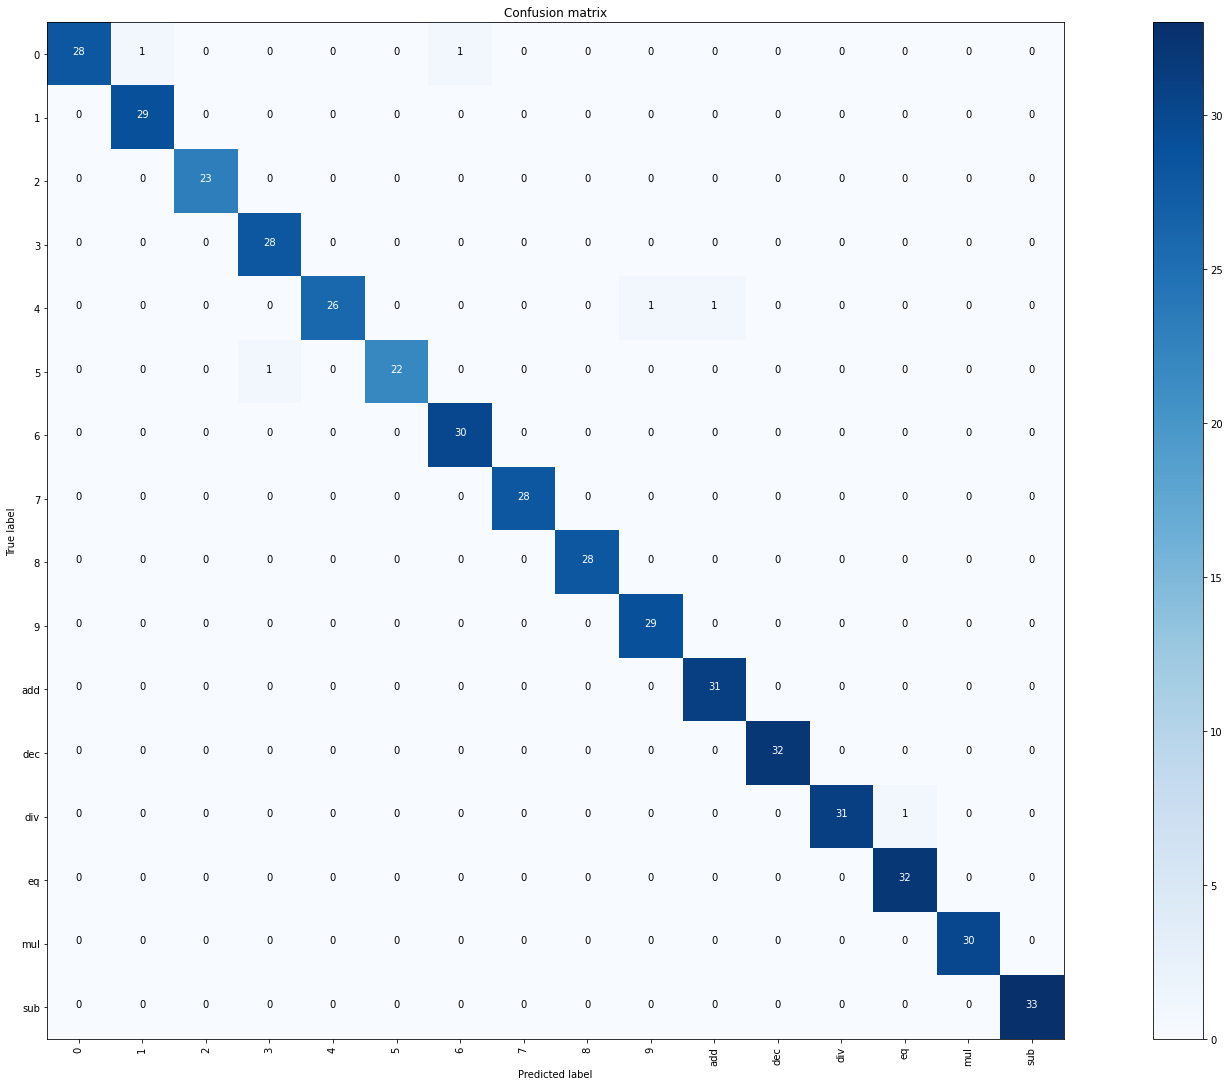

In [16]:
import itertools
classes=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'add', 'dec', 'div', 'eq', 'mul', 'sub']
len(classes)
plot_confusion_matrix(confusion_mtx, classes)
plt.show()

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred_classes)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred_classes, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred_classes, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred_classes, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred_classes, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred_classes, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred_classes, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred_classes, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred_classes, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred_classes, average='weighted')))


Accuracy: 0.99

Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.99
Macro Recall: 0.99
Macro F1-score: 0.99

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99
